In [6]:
!pip install yfinance
!pip install numpy
!pip install pandas
!pip install otter-grader
!pip install matplotlib

In [69]:
# Initialize Otter
import otter
grader = otter.Notebook("bondwindowdressing.ipynb")

# Quantitative Research Lab: Discovering Trade Ideas

This lab assignment aims to help guide you through the process of analyzing data to discover potential trading ideas in financial markets

# Importing Libraries

In [70]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Data Collection

To start, we're going to collect the data we need to analyze the effect. 

We'll use yfinance, a popular python library for accessing the yahoo finance API for asset price data

In [71]:
# BEGIN SOLUTION NO PROMPT
import yfinance as yf

# Define the ticker symbol for TLT
ticker_symbol = "TLT"

start_date = "2002-12-31"  
end_date = "2023-01-01"    

# Use yfinance to download the data
tlt_data = yf.download("TLT", start=start_date, end=end_date)
tltraw = pd.DataFrame(tlt_data)
tltraw

# END SOLUTION
""" # BEGIN PROMPT
import yfinance as yf

# Define the ticker symbol as TLT
ticker_symbol = "TLT"

start_date = "2002-12-31"  
end_date = "2023-01-01"    

# fill in the correct parameters for the download function
# yf.download (asset_symbol_to_download, start= ..., end=...)
tlt_data = yf.download(..., start=..., end=...)

# turn the data into a dataframe
tltraw = pd.DataFrame()
tltraw

""" # END PROMPT

[*********************100%%**********************]  1 of 1 completed


' # BEGIN PROMPT\nimport yfinance as yf\n\n# Define the ticker symbol as TLT\nticker_symbol = "TLT"\n\nstart_date = "2002-12-31"  \nend_date = "2023-01-01"    \n\n# fill in the correct parameters for the download function\n# yf.download (asset_symbol_to_download, start= ..., end=...)\ntlt_data = yf.download(..., start=..., end=...)\n\n# turn the data into a dataframe\ntltraw = pd.DataFrame()\ntltraw\n\n'

In [72]:
grader.check("q1")

q1 results: All test cases passed!

let's plot the data, to see how it looks!

<Axes: xlabel='Date'>

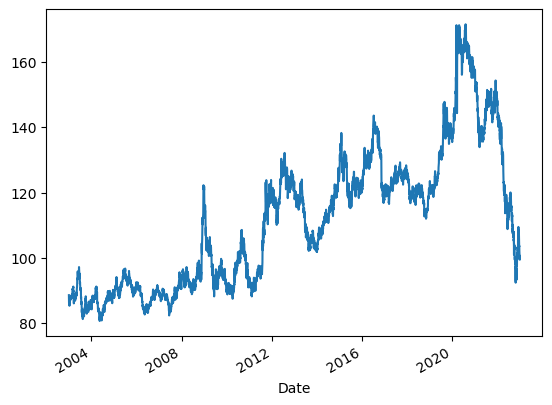

In [73]:
tltraw['Close'].plot()

<Axes: xlabel='Date'>

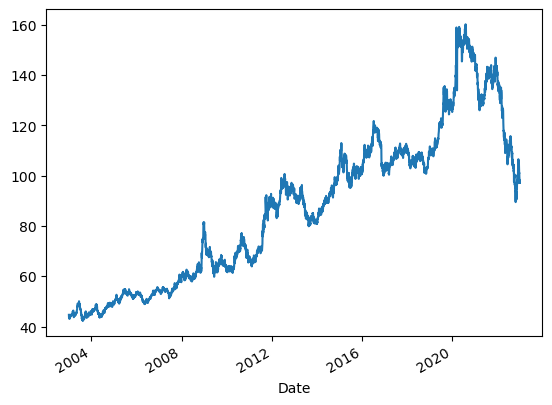

In [74]:
tltraw['Adj Close'].plot()

In [75]:
# adjusted close is basically just the close price, adjusted for stock splits and dividends
# the adjusted close price is what you would actually be able to trade, so that's what we look at

### Log vs Simple Returns

<Axes: xlabel='Date'>

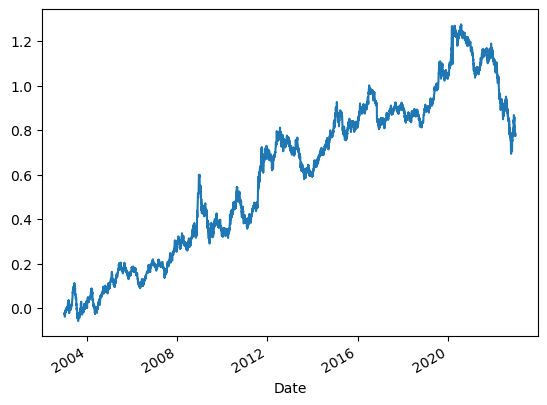

In [76]:
def simplereturn(x0,x1):
    return (x1 - x0)/x0
def logreturn(x0,x1):
    return np.log(x1/x0)
def logtosimple(r):
    return np.exp(r) - 1
    return 
def simpletolog(r):
    return np.log(1+r)

tltdf = tltraw[['Adj Close']]

tltdf['logreturn'] = logreturn(tltdf['Adj Close'].shift(1), tltdf['Adj Close']) #shift one up
tltdf
tltdf['logreturn'].cumsum().plot()

In [77]:
grader.check("q2")

q2 results: All test cases passed!

# Exploring Effect

since we're looking at an effect that happens during the beginning and end of a month, we'll want to start by grouping our data based on the day of the month

In [78]:


tltdf['dayofmonth'] = tltdf.index.day # use the index of the dataframe, and the .day accessor
dom_mean_logret = tltdf.groupby('dayofmonth')['logreturn'].mean() # input the correct column to group on, column to view, and aggregation function


In [79]:
grader.check("q3")

q3 results: All test cases passed!

now that we've grouped the data successfully, we'll look at the average logreturn by day, to see if anything interesting pops out

# what do you expect to see in the data? 

Varying returns based on day of month

<BarContainer object of 31 artists>

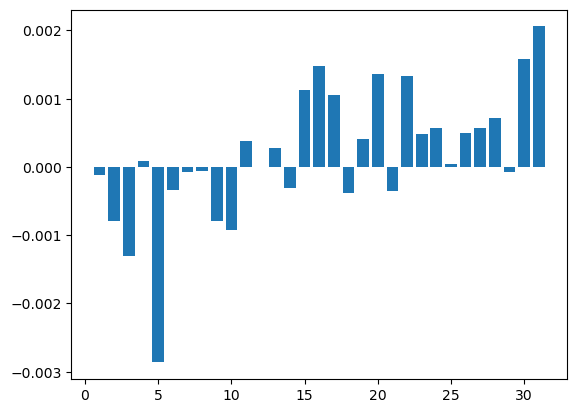

In [80]:
plt.bar(dom_mean_logret.index, dom_mean_logret)

# what do you notice in the data? 

# coming up with a basic trading rule

In [81]:


# we'll first want to group the data by months, as we're studying a month by month effect

# you can pass lists into groupby!

tltdf_months = tltdf.groupby([tltdf.index.year, tltdf.index.month])

# now, we want to create a function that we can apply to each group
# test out what one of the groups looks like, see what september 2022 looks like

sep2022 = tltdf_months.get_group((2022,9))


# try to get the sum of the log returns of the first and last 5 days
# hint: use the pandas iloc accessor

last_5_long_922 = sep2022['logreturn'].iloc[-5:].sum()
first_5_short_922 = sep2022['logreturn'].iloc[:5].sum()


In [82]:
grader.check("q4")

q4 results: All test cases passed!

calculate what would happen if we were long during the last five months, and short during the first five months

In [83]:

# generalize the above into a function that we can run on every group (test it on september 2022: you should get the same number as before)
def calculate_returns(group, n_days):
    # when we're long, last n days
    last_5_sum = group['logreturn'].iloc[-n_days:].sum()
    # when we're short, first n days
    first_5_sum = group['logreturn'].iloc[:n_days].sum()
    # combine
    return last_5_sum - first_5_sum
    

# now let's apply it to every month in the data
monthly_returns = tltdf_months.apply(calculate_returns, n_days=5)
monthly_returns


Date  Date
2002  12      0.000000
2003  1       0.019022
      2       0.016693
      3       0.012142
      4       0.036207
                ...   
2022  8       0.012310
      9       0.001306
      10      0.051335
      11      0.039671
      12     -0.106473
Length: 241, dtype: float64

In [84]:
grader.check("q5")

q5 results: All test cases passed!

here's a visualization

<Axes: xlabel='Date,Date'>

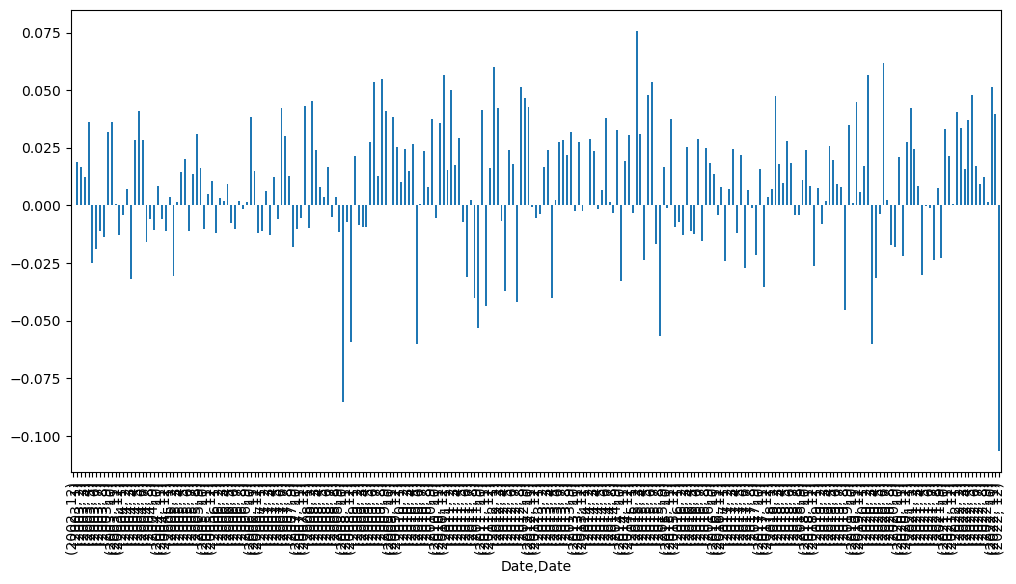

In [85]:
# Plot the bar chart
plt.figure(figsize=(12, 6))
monthly_returns.plot(kind='bar')

since we can add log returns, we add up all the log returns in the above to see how the strategy does over time

### where do you expect the strategy to do well? when do you expect it to do worse?

<Axes: xlabel='Date,Date'>

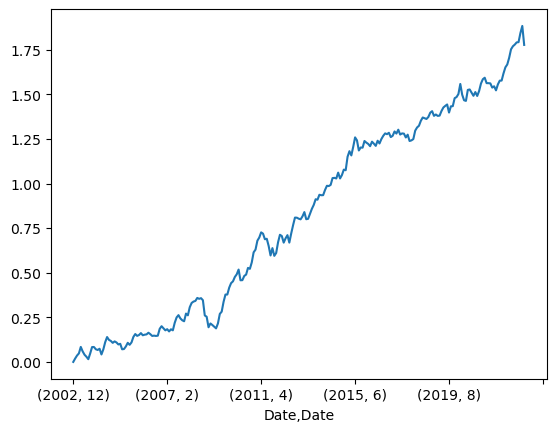

In [86]:
monthly_returns.cumsum().plot()

### where did  the strategy do well? where did it do worse?

Where the strategy did well:

Steady Growth (2002 - 2007): Starting from the inception of the strategy around the end of 2002, there's a steady upward trend. This means the strategy was consistently generating positive returns over this period.

Acceleration (2011 - 2015): There's a noticeable acceleration in the growth of returns around this period. The slope of the curve is steeper, indicating that the returns were higher during this period compared to the previous periods.

Sharp Rise (2018 - 2019): There's a pronounced spike in the growth curve around this time. This suggests a particularly strong period of performance for the strategy.

Where the strategy did worse:

Flat Period (2007 - 2011): After the initial steady growth, the curve becomes relatively flat. This suggests that the strategy wasn't generating significant returns during this period, and it could even mean there were some losses offset by gains, leading to an overall stagnant performance.

Slight Dip (2019): After the sharp rise, there's a slight downward dip in the curve. While it quickly recovers, this dip indicates a short period where the strategy underperformed or faced losses.

### what's missing from this that makes it not a 'backtest'? why wouldn't we make this much money if we started trading this today?

Transaction Costs: The plot doesn't account for the costs associated with buying and selling securities. Every time a trade is made, there are costs involved, such as broker commissions and spread costs. These costs can significantly impact the net returns of a strategy, especially if it involves frequent trading.

Slippage: This refers to the difference between the expected price of a trade and the price at which the trade is executed. In real trading, orders might not be filled at the exact prices anticipated due to market volatility. This can reduce the profitability of a strategy.

Capital Limitations: The backtest assumes that we can trade without liquidity constraints. In the real world, if a strategy involves large trade volumes, it can impact market prices and liquidity, especially in less liquid markets.

Market Impact: Large trades can influence the market price. Buying a large quantity of a security might push its price up, while selling might push it down. This can negatively impact the strategy's performance.

Data Biases: The backtest might suffer from lookahead bias or survivorship bias.

# Risk Premia Effect?

maybe the returns at the end of the month are higher because we see bigger movements at the end of the month

how can we test this?

<BarContainer object of 31 artists>

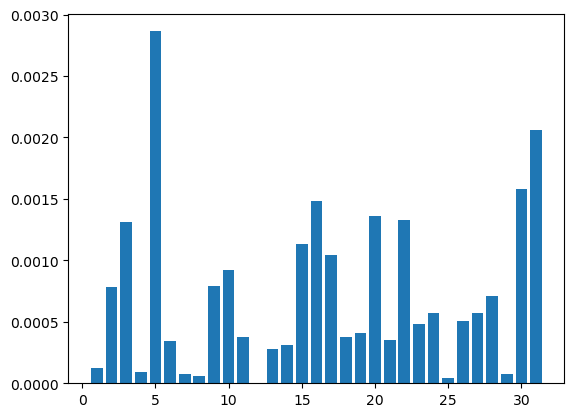

In [87]:
mean_log = tltdf.groupby('dayofmonth').mean()['logreturn']
abs_mean_log = np.abs(mean_log)
plt.bar(abs_mean_log.index, abs_mean_log)

### what does the data show? do you think this effect is a risk premia?

The data suggests that there are larger movements (either positive or negative) in returns around the start and end of the month. Specifically, around the 5th day and the last few days of the month, the absolute mean log returns appear higher. These spikes suggest greater volatility or price movement during these periods.

Institutional investors often rebalance their portfolios at the end of the month. This can result in increased buying or selling activity, leading to larger price movements. If this is the reason, it could indeed be seen as a risk premia — the additional return investors require for taking on the added risk of month-end price volatility.

However,if these movements are due to non-risk factors (like consistent behavioral biases without added risk), then it wouldn't be a classic risk premia.

# Other Assets?

lets generalize some of our functions from before, so they're easier to use in the future

[*********************100%%**********************]  1 of 1 completed


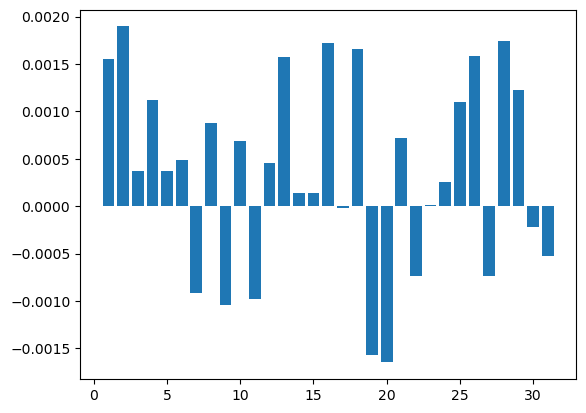

In [96]:

# lets make the downloading and preprocessing data easy to use

def processData(ticker, start_date = "2002-12-31", end_date = "2023-01-01"):
    # get data
    ticker_data = yf.download(ticker, start=start_date, end=end_date)
    ticker_raw = pd.DataFrame(ticker_data)
    ticker_df = ticker_raw[['Adj Close']]
    ticker_raw['logreturn'] = logreturn(ticker_df['Adj Close'].shift(1), ticker_df['Adj Close']) #shift one up
    return ticker_raw
    
spydf = processData(ticker="SPY")
spydf

# we can also make our plotting returns by day of month function easy to use so we can run analysis quickly

def plot_mean_dom_return(df):
    df['dayofmonth'] = df.index.day
    dom_mean_logret = df.groupby('dayofmonth')['logreturn'].mean()
    plt.bar(dom_mean_logret.index, dom_mean_logret)
    return dom_mean_logret

plot_mean_dom_return(spydf)
    
def df_months(df):
    df_months = df.groupby([df.index.year, df.index.month])
    return df_months

df_months(spydf)

grouped_spydf = df_months(spydf)
spy_monthly_returns = grouped_spydf.apply(calculate_returns, n_days=5)

# refer to how you did these things above, so you can apply it here!

In [99]:
grader.check("q6")

q6 results: All test cases passed!

# Other Ideas?

use this notebook as a playground to explore this data and effect further, if you'd like to!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [100]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1 results: All test cases passed!

    q2 results: All test cases passed!

    q3 results: All test cases passed!

    q4 results: All test cases passed!

    q5 results: All test cases passed!

    q6 results:
        q6 - 1 result:
            ✅ Test case passed

        q6 - 2 result:
            ❌ Test case failed
            Trying:
                assert((spy_monthly_returns.sum() > -0.119) and (spy_monthly_returns.sum() < -0.117))
            Expecting nothing
            **********************************************************************
            Line 1, in q6 1
            Failed example:
                assert((spy_monthly_returns.sum() > -0.119) and (spy_monthly_returns.sum() < -0.117))
            Exception raised:
                Traceback (most recent call last):
                  File "/Users/ayushman/anaconda3/lib/python